# Simple orders analysis

🚀 We are finally ready to start analysing our `orders` dataset!

Our objective is to get an initial understanding of:
- `orders` properties
- their associated `review_scores`

In [2]:
# Import Modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
%load_ext autoreload
%autoreload 2


In [4]:
# Import your newly coded _order_ training set
from olist.order import Order

# Change `with_distance_seller_customer` to False..if you have not completed the optional part of challenge 1 yet
orders = Order().get_training_data(with_distance_seller_customer=False)


In [5]:
# Check your shape below

# Shape if you set with_distance_seller_customer=True
if orders.shape[1] == 13:
    assert(orders.shape == (95872, 13))

# Shape if you set with_distance_seller_customer=False
else:
    assert(orders.shape == (96353, 12))


## 1 - Inspect features

👉 Print summary statistics of each column of the order dataset (then focus in particular on `wait_time`)

In [6]:
orders.shape

(96353, 12)

In [8]:
orders.describe()
orders[['wait_time']].describe()

,wait_time
count,96353.000000
mean,12.058472
std,9.462698
min,0.000000
25%,6.000000
50%,10.000000
75%,15.000000
max,208.000000


📈 Plot histograms to get a sense of the distribution of each numerical feature.

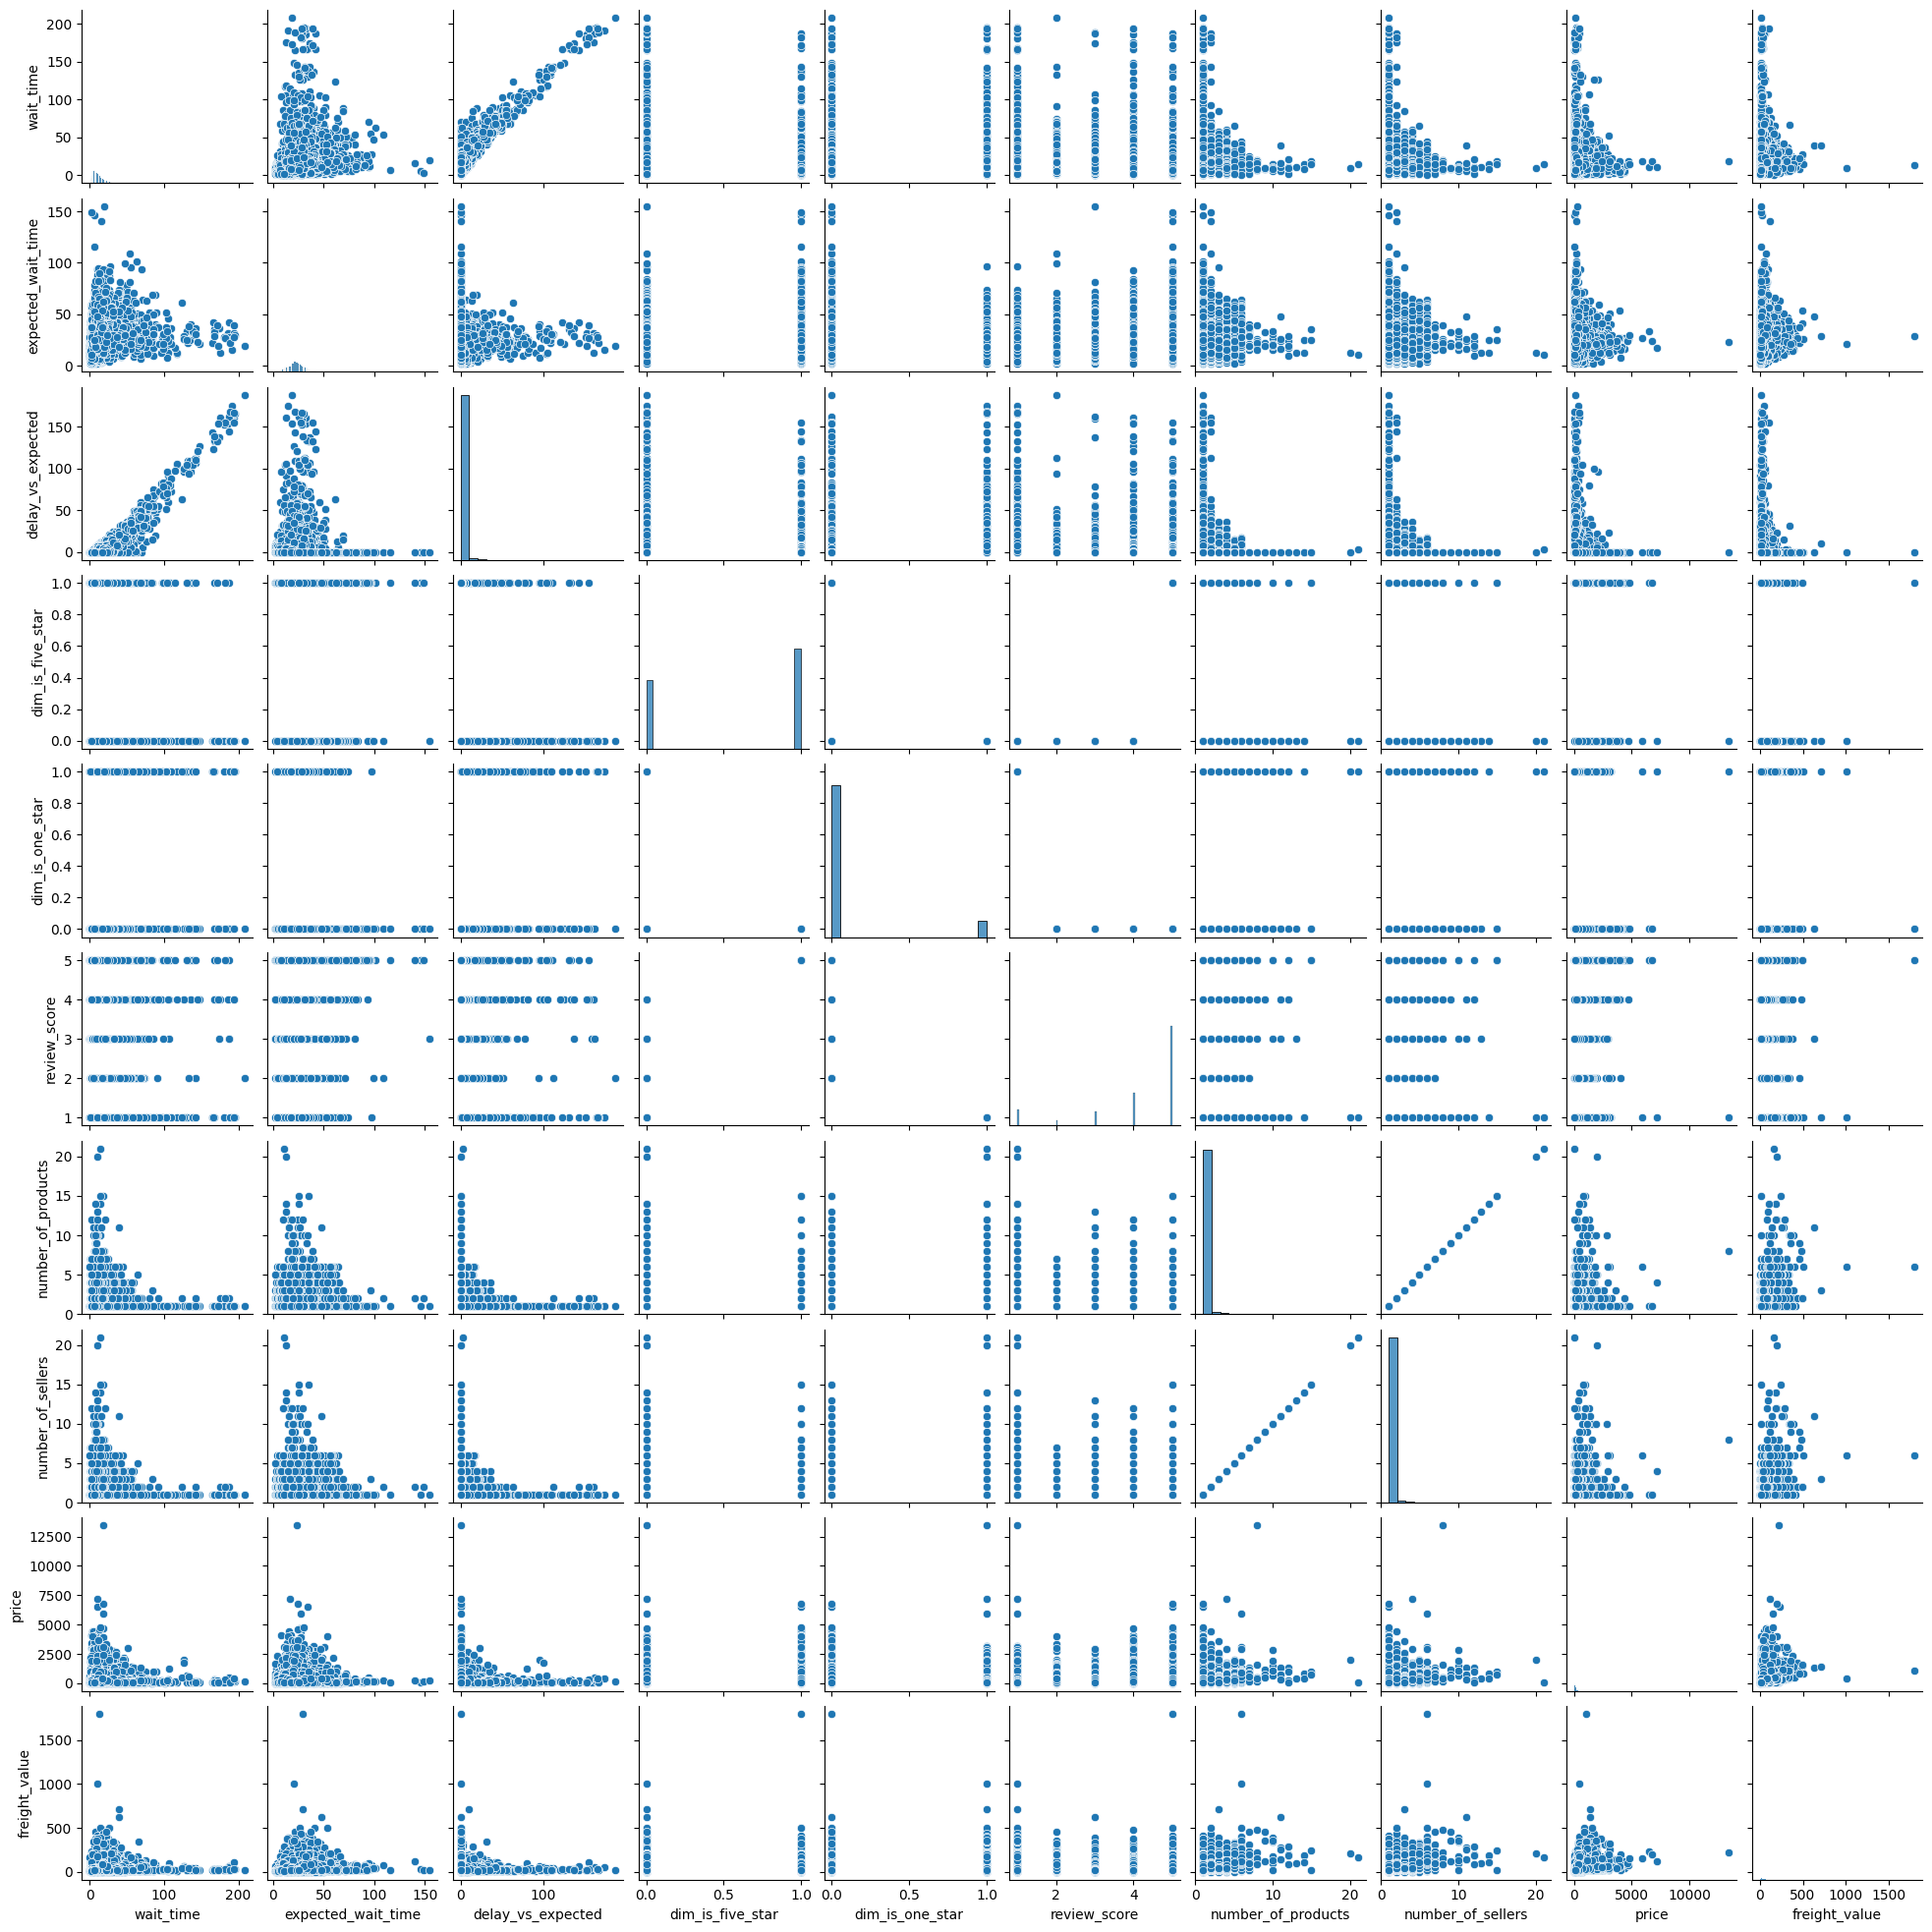

In [7]:
sns.pairplot(orders, height=2)

👀 In particular, create a `sns.FacetGrid()` of histograms for each `review_score` vs. `wait_time`

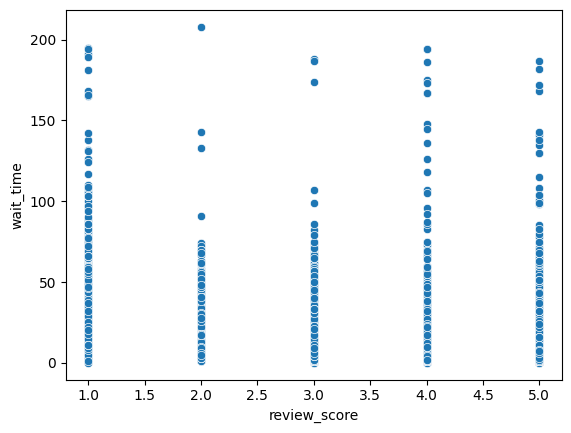

In [9]:
sns.scatterplot(x= 'review_score', y='wait_time', data=orders);

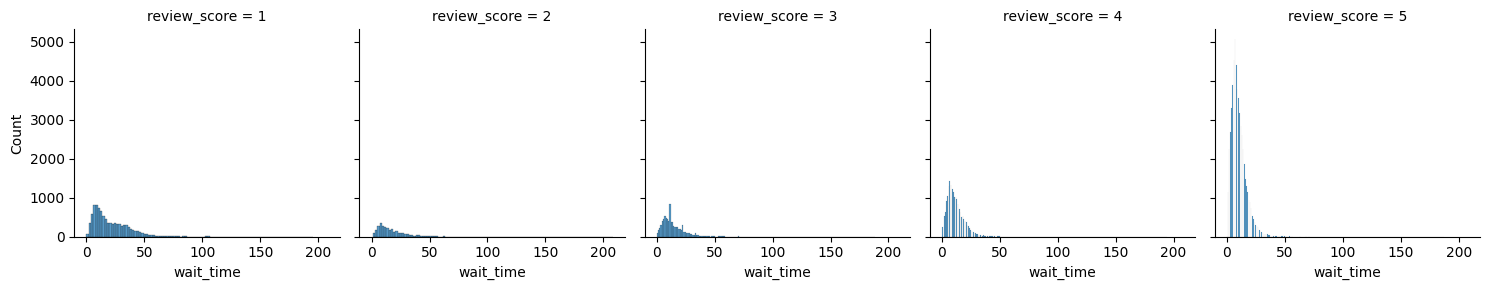

In [10]:
g= sns.FacetGrid(orders, col='review_score')
g.map(sns.histplot, 'wait_time');

❓ What do you notice for the variables `price` and `freight_value` ? 

❓ Have a look at the  `distance_seller_customer` feature if you have created it in `order.py`

In [10]:
# YOUR CODE HERE

❓Inspect the various correlations between features: which feature seems to the most correlated with `review_score`?

<details>
    <summary>▸ Hint</summary>

* Use `DataFrame.corr()` combined with `sns.heatmap()` and `cmap='coolwarm'`
* Have a look at the absolute values of the correlation coefficients of `review_score` vs. each feature,
    * the higher the coefficient, the more one given feature is correlated (positively or negatively) with the `review_score`

</details>

<AxesSubplot:>

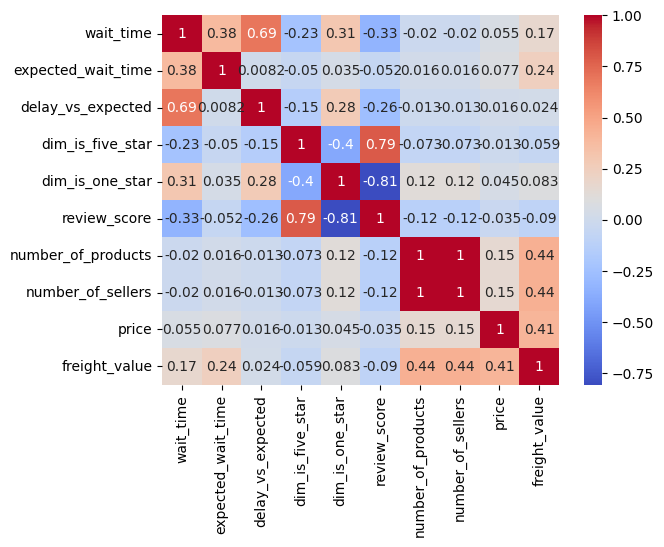

In [11]:
corr= orders.corr(method='pearson')
sns.heatmap(corr, cmap='coolwarm', annot=True)

* 😏 _Captain Obvious :_
    * `review_score` is 100% correlated to itself 
    * and strongly correlated to `dim_is_one_star` and `dim_is_five_star`...
* ⚠️ The two next highest correlation coefficients with respect to the `review_score` are :
    * `wait_time` : - 34 %
    * `delay_vs_expected` : - 27 %

## 2 - Simple regression of `review_score` against delivery duration

👉 So, it seems that `review_score` is mostly correlated with `wait_time` (= - 34%) and `delay_vs_expected` (- 27%).

🎨 Let's investigate these correlations  with `seaborn`

### 2.1 Plots
❓ In one figure, create 2 subplots, that regress `review_score` on `wait_time` and `delay_vs_expected` respectively.

<u>Tips</u>:

- Reduce your dataframe to a random sub-`sample of 10,000 rows` for speed purposes (a good practice in data exploration)
- Use `DataFrame.sample()` with a fixed `random_state` to avoid changing the sample at each execution if needed
- Use `sns.regplot()` to plot the `regression lines`
- Add some `y_jitter` parameters to better visualize the scatterplot density
- Limit `xlim` and `ylim` to hide outliers

In [12]:
orders_copy= orders.copy()
orders_random= orders_copy.sample(n=10000, random_state=1)
orders_random.shape

(10000, 12)

(0.0, 6.0)

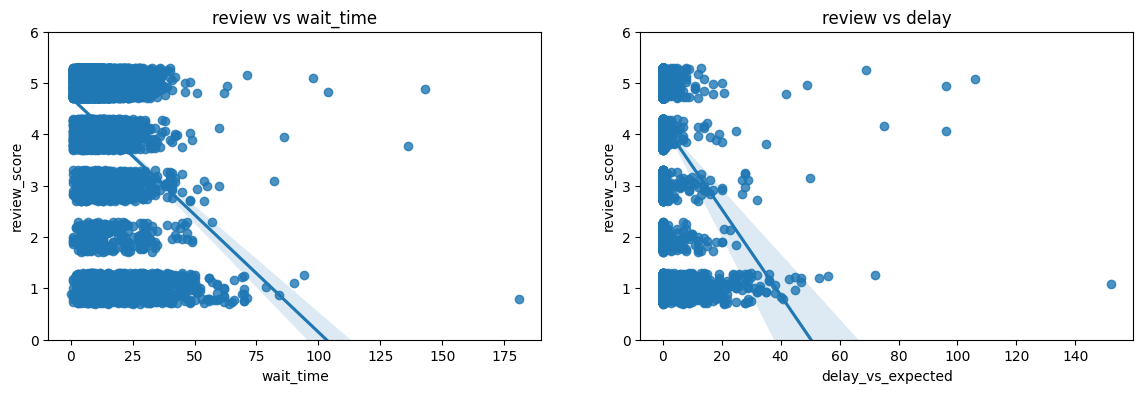

In [24]:
plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
plt.title('review vs wait_time')
sns.regplot(x='wait_time', y= 'review_score', y_jitter=0.3, data= orders_random)
plt.ylim(0,6)
plt.subplot(1,2,2)
plt.title('review vs delay')
sns.regplot(x='delay_vs_expected', y= 'review_score', y_jitter=0.3, data= orders_random)
plt.ylim(0,6)

ℹ️ What did `regplot` do ? 

👉 It tried to perform a `Linear Regression` of the `review_score` vs. `wait_time` and `delay_vs_exp` <br/> *(Cf. Day 03 - Linear Regression tomorrow)*

🧐 It doesn't look so interpretable, does it ?

👉 You are right: we have only 5  different review scores which can be interpreted as a categorical variable with five different possible values (for example: "very bad", "bad", "average", "good" and "very good") that we are trying to regress against two continuous values that are `wait_time` and `delay_vs_exp`.

👀 However, based on the regression lines, we can see a very intuitive pattern: the longer the waiting time and/or the delay, the lower the review score - Well, not surprising. But how fast does the review score decrease ?


### 2.2 Interpretation

❓Try to visually "compute" the `slope` of each curve. 

✍️ Write down, in plain English, how you would interpret these coefficients if you were to explain it to a non-data-educated audience.

> YOUR ANSWER HERE

<details>
    <summary>▸ Answer</summary>


- `Slope wait_time ≈ -0.05` : "For each additional day waiting for an order to be delivered, the review score on average is reduced by 0.05"
- `Slope delay ≈ -0.1` : "For each additional day waiting for an order to be delivered _after the ETA_, the review score on average is reduced by 0.1"

❓ Are you surprised that the delay seems more impactful than the waiting time ? 
    
👉If yes, think about it twice: you may be impatient to receive your order and would like a small wait time, but you would be even more disappointed to receive your package after the expected delivery date !
        
</details>

### 2.3 Inferential analysis

Even if we had used all 100,000 orders for these regplots, these orders represent 16 months of data after all...

⚠️⚠️⚠️ **How certain** are we that these coefficients are **statistically significant**? ⚠️⚠️⚠️

⚡️ <u> Questions about the statistical significance of these coefficients: </u>

* Are these coefficients able to generalize well to future orders (all else being equal) ? (*Ideal answer: Yes*) 
* Are we sure that these coefficients do not simply capture random fluctuations due to the limited observation period ? (*Ideal answer: No*) 

🧐 We need to estimate the **`confidence interval`** around the mean value for these two slopes  :
$$slope_{wait} = -0.05 ± \ ?? \ \text{[95\% interval]} $$
$$slope_{delay} = -0.1 ± \ ?? \ \text{[95\% interval]} $$

⭐️ Fortunately, `Seaborn` already computes this 95% confidence interval for us with a shaded blue cone around the regression line!

❓Use `Seaborn` `regplot` to visualize the two confidence intervals:
- Change the `size of your sample dataset`: 
    - Notice how the slope may change as the sample size becomes smaller. 
    - What about the confidence interval?
- Change the `size of the confidence interval` by playing with the regplot parameter called `ci` (95% by default)

(0.0, 6.0)

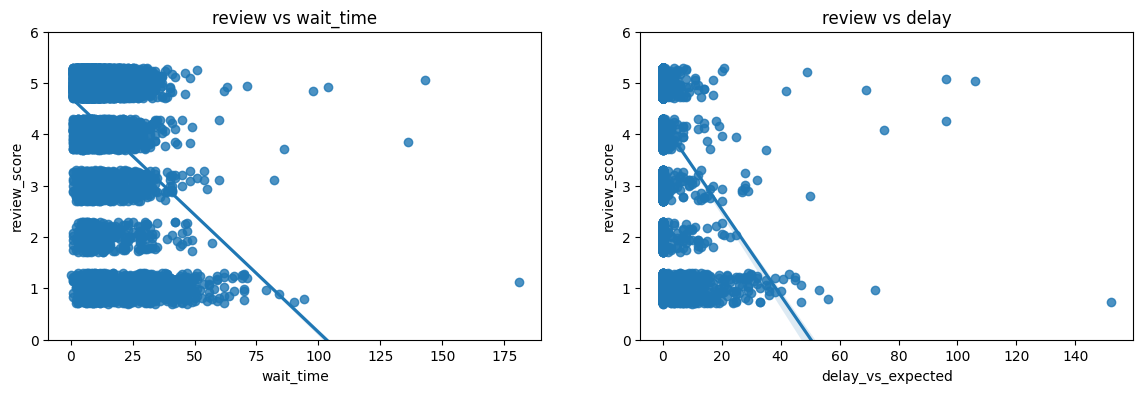

In [33]:
plt.figure(figsize= (14,4))
plt.subplot(1,2,1)
plt.title('review vs wait_time')
sns.regplot(x='wait_time', y= 'review_score', y_jitter=0.3, data= orders_random, ci=25)
plt.ylim(0,6)
plt.subplot(1,2,2)
plt.title('review vs delay')
sns.regplot(x='delay_vs_expected', y= 'review_score', y_jitter=0.3, data= orders_random, ci=25)
plt.ylim(0,6)

🔎 Interpretation:

* **Null Hypothesis** $H_0$ : "this variable does not influence the review score", a.k.a its coefficient is equal to zero

When plotting all our datapoints:
- The 95% confidence interval for the slope does not contain the value 0.
    - 👉 We are `95% confident that slower deliveries are associated with weaker reviews`.
- The **`p-value`** associated with the null hypothesis "the impact of delivery time on review scores is almost zero" is lower than 5%
    - 👉 We can safely reject this null hypothesis and consider the **`alternative hypothesis`** = `"the delivery time has an impact on the review score"` 

🔥 Our findings are said to be **statistically significant**. 

⚠️ However, **correlation does NOT imply causality**. 

- It can be inherently slower to deliver certain products (e.g.heavy products)
    - These categories of products will often have a low review_score, not matter how long their delivery time is. 

👉 Identifying **confounding factor** is crucial and cannot be done with a simple univariate regression. 

🗓 Cf. `Lecture 3 - Linear Regression` : we will talk about **`multivariate linear regression`**. 
</details>



---
🏁 Congratulations! 

🙏 Don't forget to `commit` and `push` your notebook